# (Convolutional/Variational) Autoencoders

## Import Libraries

In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


# Inspect the dataset

In [3]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


<Figure size 432x288 with 0 Axes>

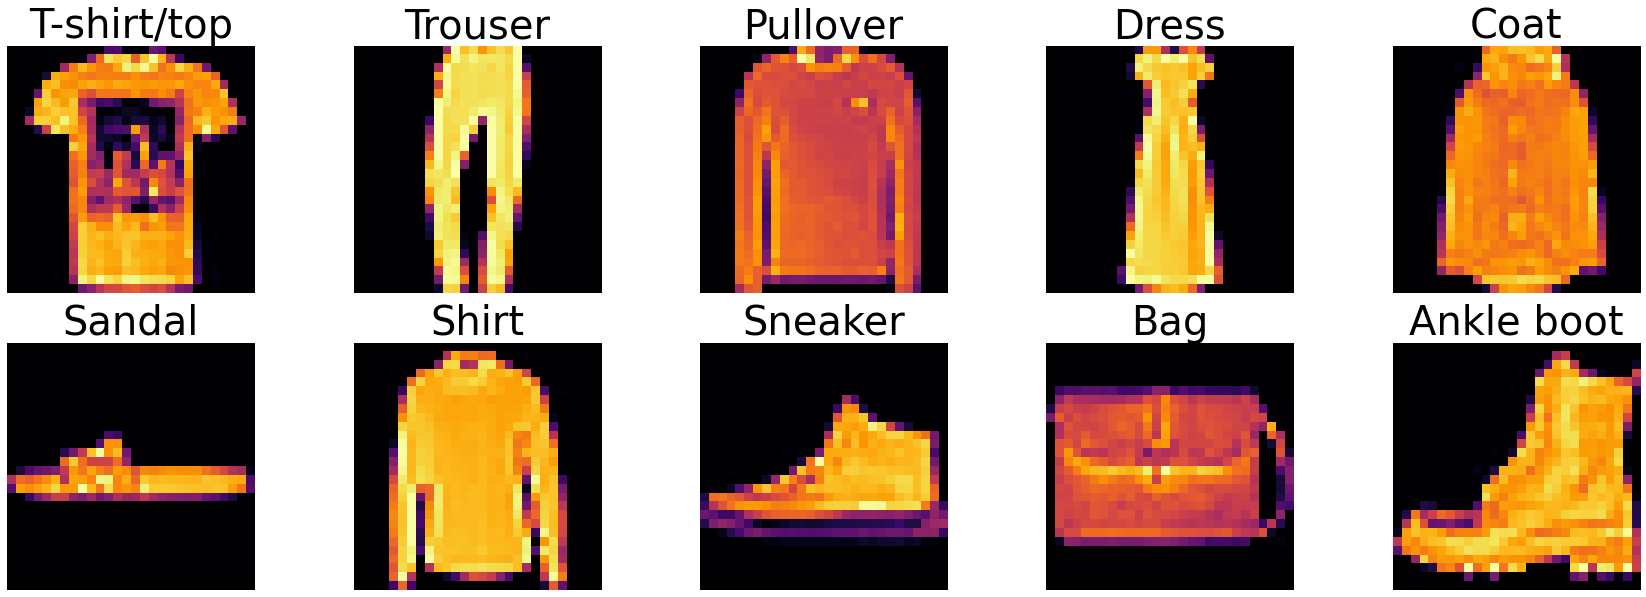

In [4]:
explicit_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Set global colormap to grayscale
#plt.gray() 
plt.inferno()

fig, ax = plt.subplots(2,5,figsize=(30,10))
for label in range(10):
    idx = np.random.choice(np.where(test_labels==label)[0])
    ax[label//5,label%5].imshow(test_images[idx])
    ax[label//5,label%5].set_title(explicit_labels[test_labels[idx]], fontsize=40)
    ax[label//5,label%5].axis("off")

# Preprocess the data

In [5]:
# Set input shape for model
my_input_shape = (28,28,1)

# Create training and test dataset form the images
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

# Normalize images and change their shape to (28,28,1)
train_dataset = train_dataset.map(lambda img: tf.cast(tf.expand_dims(img/255,-1),tf.float32),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(lambda img: tf.cast(tf.expand_dims(img/255,-1),tf.float32),
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Cache the preprocessed datasets
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

# Shuffle the data
train_dataset = train_dataset.shuffle(64)
test_dataset = test_dataset.shuffle(64)

# Create minibatches
train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)

# Prefetch the data
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Define Encoder

In [6]:
from tensorflow.keras import Model, regularizers

class ConvEncoder(Model):
    def __init__(self, embedding_size = 10):
        super(ConvEncoder, self).__init__()
        self.input_layer = tf.keras.layers.Input(my_input_shape)
        
        self.my_layers = [
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='relu'          
            ),
            tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='relu'
            ),
            tf.keras.layers.Flatten(),        
            tf.keras.layers.Dense(
                units=embedding_size,
                activation = None
            )
        ]
        
        self.out = self.call(self.input_layer)
    
    def call(self, x):
        for layer in self.my_layers:
            x = layer(x)
        return x

# Inspect Output shape of Encoder

As expected the encoder outputs a vector with a length according to the embedding size (10)

In [7]:
conv_enc = ConvEncoder()
t = conv_enc(tf.zeros([1,28,28,1]))
conv_enc.summary()

Model: "conv_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                62730     
Total params: 137,226
Trainable params: 137,226
Non-trainable params: 0
_________________________________________________________________


# Define Decoder

In [8]:
class ConvDecoder(Model):
    def __init__(self, embedding_size = 10):
        super(ConvDecoder, self).__init__()
        self.input_layer = tf.keras.layers.Input(embedding_size)
        
        self.my_layers = [
            tf.keras.layers.Dense(
                units=7*7*128, 
                activation='relu'
            ),
            tf.keras.layers.Reshape(
                target_shape=(7,7,128)
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=64,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='relu'
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=1,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='sigmoid'
            )            
        ]
        
        self.out = self.call(self.input_layer)
        
    def call(self, x):
        for layer in self.my_layers:
            x = layer(x)
        return x        

# Inspect Output shape of Decoder

As expected the decoder outputs an array of the same shape as the original input image

In [9]:
conv_dec = ConvDecoder()
_ = conv_dec(conv_enc(tf.zeros([1,28,28,1])))
conv_dec.summary()

Model: "conv_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              68992     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        73792     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         577       
Total params: 143,361
Trainable params: 143,361
Non-trainable params: 0
_________________________________________________________________


# Define full Autoencoder

In [10]:
class ConvAutoencoder(Model):
    def __init__(self, embedding_size = 10):
        super(ConvAutoencoder, self).__init__()
        self.input_layer = tf.keras.layers.Input(my_input_shape)
        
        self.encoder = ConvEncoder(embedding_size)
        
        self.decoder = ConvDecoder(embedding_size)
        
        self.out = self.call(self.input_layer)

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
conv_enc_dec = ConvAutoencoder()
_ = conv_enc_dec(tf.zeros([1,28,28,1]))
conv_enc_dec.summary()

Model: "conv_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_encoder_1 (ConvEncoder) (None, 10)                137226    
_________________________________________________________________
conv_decoder_1 (ConvDecoder) (None, 28, 28, 1)         143361    
Total params: 280,587
Trainable params: 280,587
Non-trainable params: 0
_________________________________________________________________


# Test the Autoencoder

As expected the decoded images are just noise

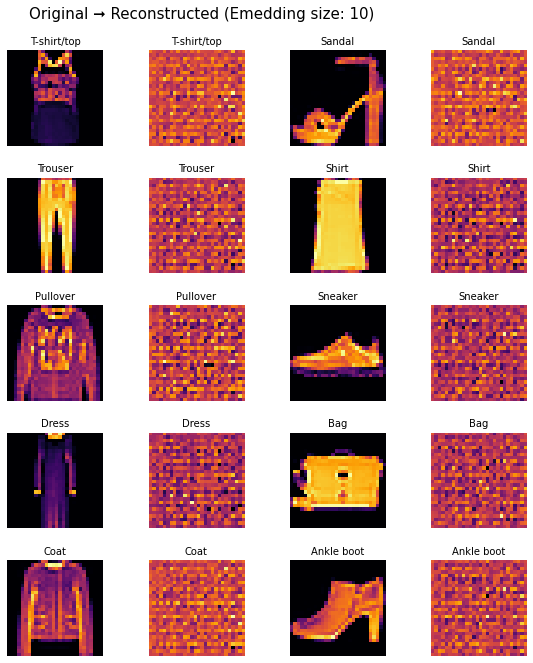

In [12]:
model = ConvAutoencoder()
embedding_size=10
fig, ax = plt.subplots(5,4,figsize=(8,20))
fig.suptitle(f'Original \u279e Reconstructed (Emedding size: {embedding_size})', fontsize=15, x = 0.40, y = 0.97)
fig.tight_layout(rect=[0, 0.5, 1, 0.95])
for cat in range(10):
    idx = np.random.choice(np.where(test_labels==cat)[0])
    ax[cat%5,0+ cat//5*2].imshow(test_images[idx])
    ax[cat%5,0+ cat//5*2].set_title(explicit_labels[test_labels[idx]], fontsize=10)
    ax[cat%5,0+ cat//5*2].axis("off")

    ax[cat%5,1+ cat//5*2].imshow(model(np.expand_dims(test_images[idx]/255,(0,-1)).astype(np.float32)).numpy().squeeze())
    ax[cat%5,1+ cat//5*2].set_title(explicit_labels[test_labels[idx]], fontsize=10)
    ax[cat%5,1+ cat//5*2].axis("off")

# Define variational Autoencoder

In [13]:
class VarAE(Model):

    def __init__(self, embedding_size = 10):
        super(VarAE, self).__init__()

        self.encoder = [
                tf.keras.layers.Conv2D(
                                  filters = 512, #32
                                  kernel_size = 4,
                                  strides = 1,
                                  padding = 'same',
                                  activation = 'relu',
                                  input_shape = (28, 28, 1)),

                tf.keras.layers.Conv2D(
                                  filters = 256, #64
                                  kernel_size = 3, 
                                  strides = (2, 2), 
                                  activation='relu'),

                tf.keras.layers.Conv2D(
                                  filters = 128, #128
                                  kernel_size = 2, # 3
                                  strides = 1, # (2, 2)
                                  activation ='relu'),

                tf.keras.layers.Conv2D(
                                  filters = 64, #none
                                  kernel_size = 1, # 3 
                                  strides = 1, #(2, 2)
                                  activation ='relu'),

                tf.keras.layers.Flatten(),


                # we need 2 times the embedding units because we have to account
                # for both the mean µ and the standard deviation σ
                tf.keras.layers.Dense(
                                  embedding_size + embedding_size,
                                  activation = None),
            ]


        self.decoder = [
                # The input shape for the first decoding layer has again the shape
                # of the embedding size, because we sample one embedding value 
                # for each (µ and σ) pair
                tf.keras.layers.InputLayer(input_shape=(embedding_size)),
                tf.keras.layers.Dense(units=7*7*64, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=2, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=128, kernel_size=2, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=2, strides=1, padding='same',
                    activation = None),
            ]

      # Because we cant backpropergate through probability distributions
      # but instead need concrete values that are fixed 
      # at the time of computation, we reparameterize.
      # This reparameterization trick is really just sampling with extra steps.
      # We sample ε from a normal distribution with mean = 0 and sigma = 1
      # and then calculate the encoding value
      # z = µ + σ*ε
    def reparameterize(self, mean, logvar):
        e = tf.random.normal(shape = mean.shape)
        return mean + tf.exp(logvar * .5) * e


    def sample(self, eps = None):
        if eps is None:
          eps = tf.random.normal(self.latent_dim)
        return self(eps, "decode")


      # Depending in whether we pass "encode" or "decode"
      # we feed the input through the respective parts of the network
    def call(self, x, mode = None):

        if mode == "encode":
            for layer in self.encoder:
                x = layer(x)
            return tf.split(x, num_or_size_splits=2, axis=1)

        elif mode == "decode":
            for layer in self.decoder:
                x = layer(x)
            return x

        else:
            for layer in self.encoder:
                x = layer(x)

            x = self.reparameterize(*tf.split(x, num_or_size_splits=2, axis=1))
            for layer in self.decoder:
                x = layer(x)
            return x

## Why we assume that the standard variation is in logarithmic form
Because we dont restrict the output of our encoder, we get positive and negative values. <br>
While the positve values are fine, a negative sigma does not make much sense.<br>
But if we take a look at the graph below we see that in the logarithmic form <br>
the sd takes both positive and negative.

So we just act like our values where logarithmic all along and then transform them back using exp()

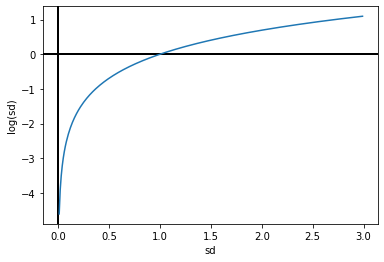

In [14]:
sd = np.arange(0.01, 3.0, 0.01)
log_sd = np.log(sd)
fig, ax = plt.subplots()
ax.axhline(y=0, linewidth=2, color='black')
ax.axvline(x=0, linewidth=2, color='black')
ax.plot(sd, log_sd)
ax.set(xlabel='sd', ylabel='log(sd)')
plt.show()

# Define variational Encoder using tfp

The Encoder returns a multivariate normal distribution describing the latent space

In [15]:
import tensorflow_probability as tfp

class VarEncoderTFP(Model):
    def __init__(self, embedding_size = 10):
        super(VarEncoderTFP, self).__init__()        
        self.embedding_size = embedding_size
        
        self.input_layer = tf.keras.layers.Input(my_input_shape)
        
        self.my_layers = [
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='relu'          
            ),
            tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='relu'
            ),
            tf.keras.layers.Flatten(),        
            tf.keras.layers.Dense(
                units=self.embedding_size*2,
                activation = None
            )
        ]        
        
        self.out = self.call(self.input_layer)
    
    def call(self, x):
        for layer in self.my_layers:
            x = layer(x)
        # Define the multivariate normal distribution 
        # using the first half of the output of the dense layer as mean and the second half as variance
        x = tfp.distributions.MultivariateNormalDiag(loc=x[:,:self.embedding_size], scale_diag=x[:,self.embedding_size:])
        return x

In [16]:
var_enc = VarEncoderTFP()
t = var_enc(tf.zeros([1,28,28,1]))
var_enc.summary()

Model: "var_encoder_tfp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                125460    
Total params: 199,956
Trainable params: 199,956
Non-trainable params: 0
_________________________________________________________________


# Define variational Decoder using tfp

The decoder takes a sample from the distribution of the encoder and returns a bernoulli distribution for each pixel of the image to take value 1 or 0

In [17]:
class VarDecoderTFP(Model):
    def __init__(self, embedding_size = 10):
        super(VarDecoderTFP, self).__init__()
        self.input_layer = tf.keras.layers.Input(embedding_size)
        
        self.my_layers = [
            tf.keras.layers.Dense(
                units=6272, 
                activation='relu'
            ),
            tf.keras.layers.Reshape(
                target_shape=(7,7,128)
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=64,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='relu'
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=1,
                kernel_size=3,
                strides=2,
                padding='same',
                activation=None
            ),
            tf.keras.layers.Flatten(),
            tfp.layers.IndependentBernoulli(my_input_shape, tfp.distributions.Bernoulli.logits),
        ]
        
        self.out = self.call(self.input_layer)
        
    def call(self, x):
        for layer in self.my_layers:
            x = layer(x)
        return x        

In [18]:
var_dec = VarDecoderTFP()
t = var_dec(var_enc(tf.zeros([1,28,28,1])).sample())
var_dec.summary()

Model: "var_decoder_tfp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 6272)              68992     
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 1)         577       
_________________________________________________________________
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
independent_bernoulli (Indep ((None, 28, 28, 1), (None 0         
Total params: 143,361
Trainable params: 143,361
Non-trainable params: 0
_____________________________________________

# Define variational Autoencoder using tfp

In [19]:
class VarAutoencoderTFP(Model):
    def __init__(self, prior, embedding_size = 10):
        super(VarAutoencoderTFP, self).__init__()
        self.prior = prior
        self.input_layer = tf.keras.layers.Input(my_input_shape)
        
        self.encoder = VarEncoderTFP(embedding_size)
        
        self.decoder = VarDecoderTFP(embedding_size)
        
        self.out = self.call(self.input_layer)

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x.sample())
        return x

In [21]:
prior = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(embedding_size), scale_diag=tf.ones(embedding_size))
var_enc_dec = VarAutoencoderTFP(prior)
_ = var_enc_dec(tf.zeros([1,28,28,1]))
var_enc_dec.summary()

Model: "var_autoencoder_tfp_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
var_encoder_tfp_2 (VarEncode multiple                  199956    
_________________________________________________________________
var_decoder_tfp_2 (VarDecode (None, 28, 28, 1)         143361    
Total params: 343,317
Trainable params: 343,317
Non-trainable params: 0
_________________________________________________________________


# Define the training process

#### Function to plot the models performance

In [22]:
from IPython.display import clear_output

def visualize_progress(model, num_epochs, epoch, train_losses, test_losses):
    clear_output(wait=True)
    fig = plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    plt.xlim((0,num_epochs))
    plt.plot(train_losses,label='Training')
    plt.plot(test_losses,label='Test')
    plt.ylabel('Loss',fontsize=24)
    plt.xlabel('Epochs',fontsize=24)
    plt.title(f'Epoch: {epoch+1}', fontweight='bold')
    plt.xticks(np.arange(0,num_epochs,2))
    plt.legend()

    idx = np.random.choice(test_images.shape[0])
    decoder_out = model(np.expand_dims(test_images[idx]/255,(0,-1)).astype(np.float32))
    
    plt.subplot(2,2,3)
    plt.imshow(test_images[idx])
    plt.title(f'Original ({explicit_labels[test_labels[idx]]})', fontsize=20)
    plt.axis("off")
    plt.subplot(2,2,4)
    if isinstance(decoder_out, tfp.distributions.Distribution):
        plt.imshow(decoder_out.mean().numpy().squeeze())
    else:
        plt.imshow(decoder_out.numpy().squeeze())
        
    plt.title(f'Reconstructed ({explicit_labels[test_labels[idx]]})', fontsize=20)
    plt.axis("off")
    fig.tight_layout()
    plt.show() 

#### Function to train a given model on a given dataset with given hyperparameter
In the end we get back a dictionary containing the performance measures of the model

In [23]:
def train_model(model, train_dataset, test_dataset, num_epochs, loss_function, optimizer):
    running_average_factor = 0.95
    
    # Initialize lists for later visualization.
    train_losses = []
    test_losses = []

    # Testing model performance on train and test data before learning
    train_loss = test(model, train_dataset, loss_function)
    train_losses.append(train_loss)

    test_loss = test(model, test_dataset, loss_function)
    test_losses.append(test_loss)

    # Display loss and accuracy before training
    print('Starting loss:')
    print('Train loss: ',train_loss)
    print('Test loss: ',test_loss)

    # Train loop for num_epochs epochs.
    for epoch in range(num_epochs):
        # Training
        running_average_loss = 0
        for model_input in train_dataset:
            train_loss = train_step(model, model_input, loss_function, optimizer)
            running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
            
        train_losses.append(running_average_loss.numpy())

        # Testing
        test_loss = test(model, test_dataset, loss_function)
        test_losses.append(test_loss)

        #Dynamically visualize the training progress
        visualize_progress(model, num_epochs, epoch, train_losses, test_losses)

        # Display loss and accuracy for current epoch
        print('Train loss: ',running_average_loss.numpy())
        print('Test loss: ',test_loss)
    
    model_performance = {
        "train_loss": train_losses,
        "test_loss": test_losses
    }
    return model_performance

# Define training and testing for convolutional AE

In [24]:
@tf.function
def train_step(model, model_input, loss_function, optimizer):
    with tf.GradientTape() as tape:
        decoded = model(model_input)
        loss = loss_function(model_input, decoded)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function
def performance_calc(model, model_input, loss_function):
    decoded = model(model_input)
    loss = loss_function(model_input, decoded)
    return loss

def test(model, dataset, loss_function):
    # Test over complete test data
    test_loss_aggregator = []

    for model_input in dataset:
        loss = performance_calc(model, model_input, loss_function)
        test_loss_aggregator.append(loss.numpy())

    test_loss = np.mean(test_loss_aggregator)

    return test_loss

# Train convolutional Autoencoder

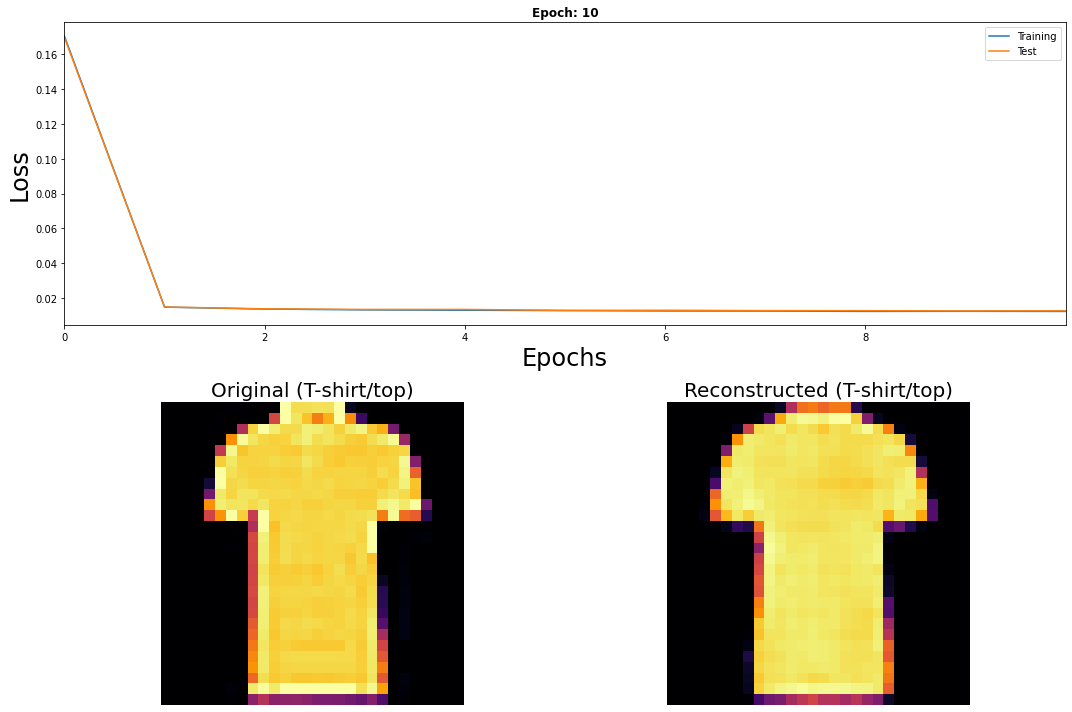

Train loss:  0.012226402
Test loss:  0.012577031
CPU times: user 34 s, sys: 3.9 s, total: 37.9 s
Wall time: 32.2 s


In [25]:
%%time
tf.keras.backend.clear_session()

learning_rate = 0.01
embedding_size = 10
epochs = 10

# Initialize the loss
loss_function = tf.keras.losses.MeanSquaredError()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize model
convAE = ConvAutoencoder(embedding_size)
convAE_performance = train_model(
    model = convAE,
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    num_epochs = epochs,
    loss_function = loss_function,
    optimizer = optimizer
)

# Visualize results for each category

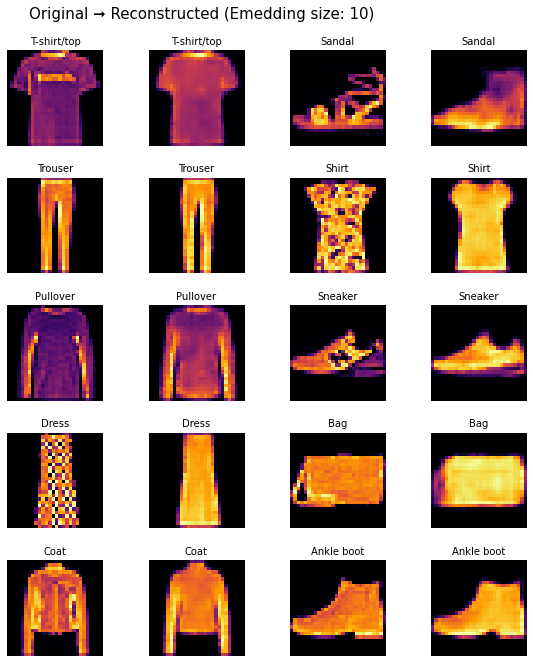

In [26]:
fig, ax = plt.subplots(5,4,figsize=(8,20))
fig.suptitle(f'Original \u279e Reconstructed (Emedding size: {embedding_size})', fontsize=15, x = 0.40, y = 0.97)
fig.tight_layout(rect=[0, 0.5, 1, 0.95])
for cat in range(10):
    idx = np.random.choice(np.where(test_labels==cat)[0])
    ax[cat%5,0+ cat//5*2].imshow(test_images[idx])
    ax[cat%5,0+ cat//5*2].set_title(explicit_labels[test_labels[idx]], fontsize=10)
    ax[cat%5,0+ cat//5*2].axis("off")

    ax[cat%5,1+ cat//5*2].imshow(convAE(np.expand_dims(test_images[idx]/255,(0,-1)).astype(np.float32)).numpy().squeeze())
    ax[cat%5,1+ cat//5*2].set_title(explicit_labels[test_labels[idx]], fontsize=10)
    ax[cat%5,1+ cat//5*2].axis("off")

In [31]:
convAE.summary()

Model: "conv_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_encoder (ConvEncoder)   (None, 10)                137226    
_________________________________________________________________
conv_decoder (ConvDecoder)   (None, 28, 28, 1)         143361    
Total params: 280,587
Trainable params: 280,587
Non-trainable params: 0
_________________________________________________________________


# Define training and testing for variational AE

In [27]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


# vae cost function as negative ELBO
def vae_cost(model, x_true, analytic_kl=True, kl_weight=0.5):
    mu, sd = model(x_true, "encode")
    z_sample = model.reparameterize(mu, sd)
    x_recons_logits = model(z_sample, "decode")
    
    # compute cross entropy loss for each dimension of every datapoint (pixel).
    # This tells us the negative log likelihood of a pixel given the encoding
    # so - log p(x|z)
    # The negative log likelihood is the first part of our ELBO loss
    # it gives us feedback about how well the en- and decoding worked
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits)  

    # compute cross entropy loss for all instances in mini-batch; shape=(batch_size,)
    neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])

    # compute reverse KL divergence, either analytically 
    # or through MC approximation with one sample
    # The KL divergence is the second part of the elbo loss
    # it keeps the  “distance” between prior p(z) and posterior distribution p(z|x) 
    # of the embedding in check
    # We can manage how hard this distance should be punished by changing kl_weight
    if analytic_kl:
        kl_divergence = - 0.5 * tf.math.reduce_sum(
            1 + tf.math.log(tf.math.square(sd)) - tf.math.square(mu) - tf.math.square(sd),
            axis=1)  # shape=(batch_size, )
    else:
        logpz = normal_log_pdf(z_sample, 0., 1.)  # shape=(batch_size,)
        logqz_x = normal_log_pdf(z_sample, mu, tf.math.square(sd))  # shape=(batch_size,)
        kl_divergence = logqz_x - logpz
    elbo = tf.math.reduce_mean(-kl_weight * kl_divergence - neg_log_likelihood)  
    return -elbo


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = vae_cost(model, x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
    return loss



def test(model, test_data):
    # Test over complete test data

    test_loss_aggregator = []

    for x in test_data:
        mean, logvar = model(x, "encode")
        z = model.reparameterize(mean, logvar)
        x_logit = model(z, "decode")
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)

        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = log_normal_pdf(z, mean, logvar)
        sample_test_loss = -tf.reduce_mean(logpx_z + logpz - logqz_x)
        test_loss_aggregator.append(sample_test_loss.numpy())

    test_loss = np.mean(test_loss_aggregator)

    return test_loss

# Train variational Autoencoder

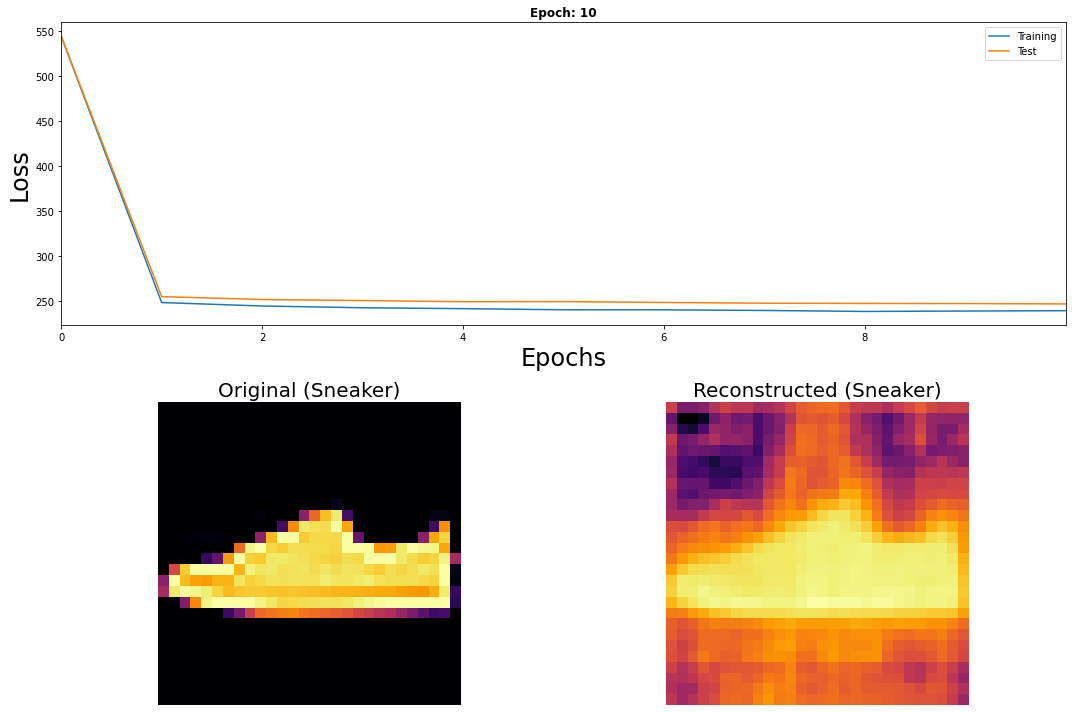

Train loss:  239.069069240208
Test loss:  246.60843
CPU times: user 4min 35s, sys: 2min 23s, total: 6min 59s
Wall time: 6min 53s


In [28]:
%%time
tf.keras.backend.clear_session()
from IPython.display import clear_output

### Hyperparameters
num_epochs = 10
learning_rate = 0.001
embedding_size = 10
running_average_factor = 0.95

varAE = VarAE(embedding_size)

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []

# Testing model performance on train and test data before learning
train_loss = test(varAE, train_dataset)
train_losses.append(train_loss)


test_loss = test(varAE, test_dataset)
test_losses.append(test_loss)

# Train loop for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    # Training
    running_average_loss = 0
    for image in train_dataset:
        train_loss = np.mean(train_step(varAE, image, optimizer))
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
        
    train_losses.append(running_average_loss)
   

    # Testing
    test_loss = test(varAE, test_dataset)
    test_losses.append(test_loss)

    #Dynamically visualize the training progress
    visualize_progress(varAE, num_epochs, epoch, train_losses, test_losses)

    print('Train loss: ',running_average_loss)
    print('Test loss: ',test_loss)

# Visualize results for each category

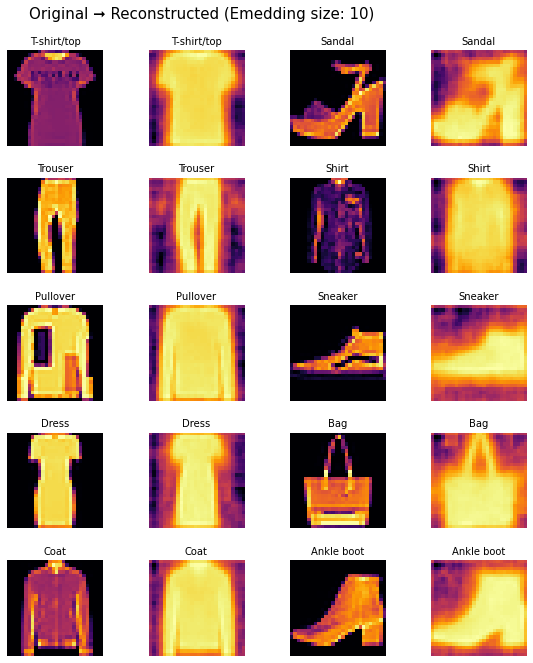

In [29]:
fig, ax = plt.subplots(5,4,figsize=(8,20))
fig.suptitle(f'Original \u279e Reconstructed (Emedding size: {embedding_size})', fontsize=15, x = 0.40, y = 0.97)
fig.tight_layout(rect=[0, 0.5, 1, 0.95])
for cat in range(10):
    idx = np.random.choice(np.where(test_labels==cat)[0])
    ax[cat%5,0+ cat//5*2].imshow(test_images[idx])
    ax[cat%5,0+ cat//5*2].set_title(explicit_labels[test_labels[idx]], fontsize=10)
    ax[cat%5,0+ cat//5*2].axis("off")

    ax[cat%5,1+ cat//5*2].imshow(varAE(np.expand_dims(test_images[idx]/255,(0,-1)).astype(np.float32)).numpy().squeeze())
    ax[cat%5,1+ cat//5*2].set_title(explicit_labels[test_labels[idx]], fontsize=10)
    ax[cat%5,1+ cat//5*2].axis("off")

In [30]:
varAE.summary()

Model: "var_ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  8704      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  1179904   
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  131200    
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  8256      
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  184340    
_________________________________________________________________
input_1 (InputLayer)         [(None, 10)]              0    

# Define training and testing for variational AE using tfp

In [32]:
@tf.function
def train_step(model, model_input, loss_function, optimizer):
    with tf.GradientTape() as tape:
        decoded = model(model_input)
        loss = loss_function(model, model_input, decoded)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return tf.reduce_mean(loss)

@tf.function
def performance_calc(model, model_input, loss_function):
    decoded = model(model_input)
    loss = loss_function(model, model_input, decoded)
    return loss

def test(model, dataset, loss_function):
    # Test over complete test data
    test_loss_aggregator = []

    for model_input in dataset:
        loss = performance_calc(model, model_input, loss_function)
        test_loss_aggregator.append(np.mean(loss.numpy()))

    test_loss = np.mean(test_loss_aggregator)

    return test_loss

# Define ELBO loss

In [33]:
def ELBO(model, model_input, model_output):
    # Get the embedded distribution of the model
    embedding = model.encoder(model_input)
    
    # Compute the KLdivergence between the embedded distribution and the prior
    KL = embedding.kl_divergence(model.prior)
    
    # Calculate the log likelihood of the decoder
    log_likelihood_out = model_output.log_prob(model_input)
    
    elbo = -log_likelihood_out + KL
    
    return elbo

# Train variational Autoencoder using tfp

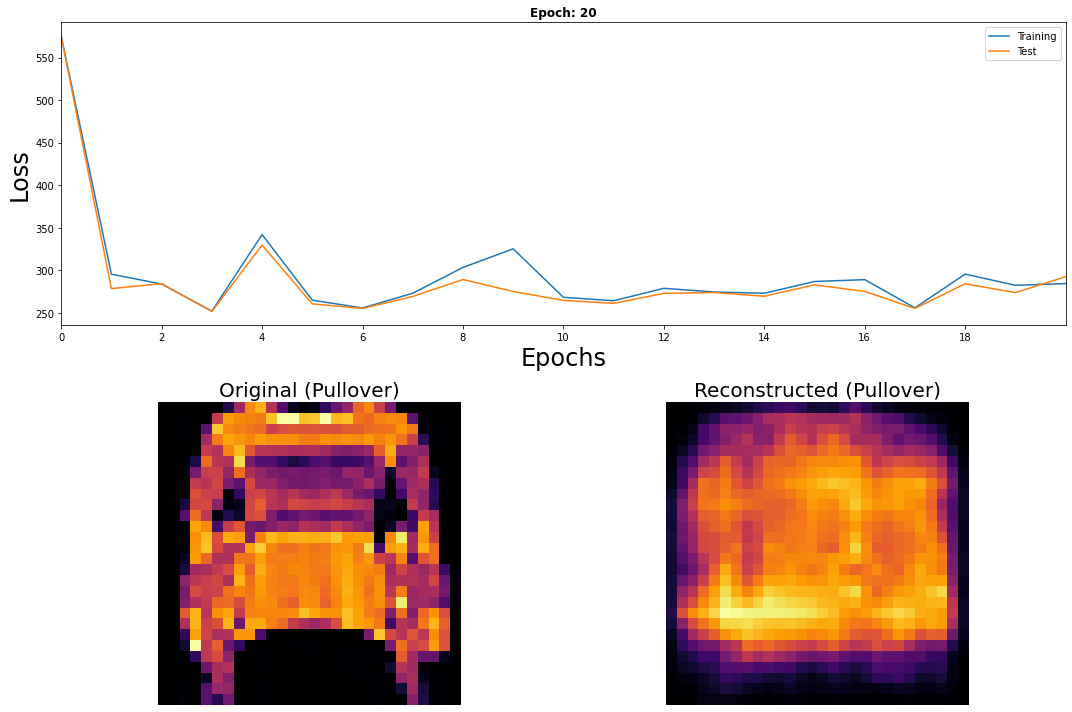

Train loss:  284.42288
Test loss:  292.5405
CPU times: user 1min 26s, sys: 7.21 s, total: 1min 33s
Wall time: 1min 30s


In [34]:
%%time
tf.keras.backend.clear_session()

learning_rate = 0.001
embedding_size = 10
epochs = 20

# Define a prior for the encoders embedding
# We want the embedding to be from a Multivariate Normal distribution thats centered at 0
prior = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(embedding_size), scale_diag=tf.ones(embedding_size))

# Initialize the loss
loss_function = ELBO

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize model
var_tfp_AE = VarAutoencoderTFP(prior, embedding_size)
var_tfp_AE_performance = train_model(
    model = var_tfp_AE,
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    num_epochs = epochs,
    loss_function = loss_function,
    optimizer = optimizer
)

# Visualize results for each category

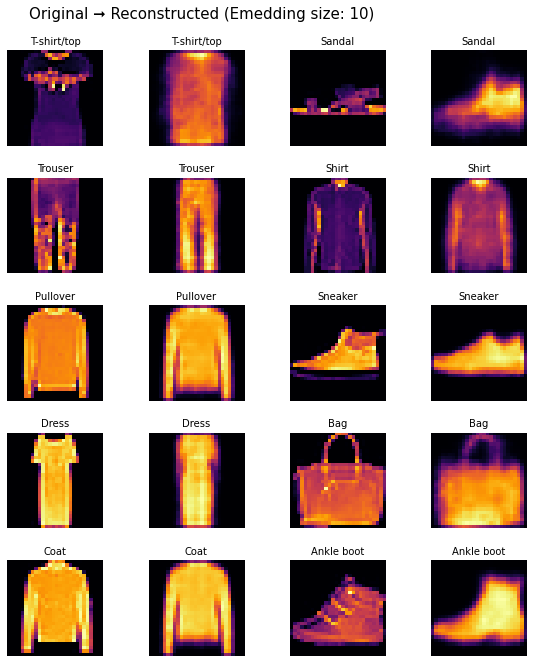

In [35]:
fig, ax = plt.subplots(5,4,figsize=(8,20))
fig.suptitle(f'Original \u279e Reconstructed (Emedding size: {embedding_size})', fontsize=15, x = 0.40, y = 0.97)
fig.tight_layout(rect=[0, 0.5, 1, 0.95])
for cat in range(10):
    idx = np.random.choice(np.where(test_labels==cat)[0])
    ax[cat%5,0+ cat//5*2].imshow(test_images[idx])
    ax[cat%5,0+ cat//5*2].set_title(explicit_labels[test_labels[idx]], fontsize=10)
    ax[cat%5,0+ cat//5*2].axis("off")

    ax[cat%5,1+ cat//5*2].imshow(var_tfp_AE(np.expand_dims(test_images[idx]/255,(0,-1)).astype(np.float32)).mean().numpy().squeeze())
    ax[cat%5,1+ cat//5*2].set_title(explicit_labels[test_labels[idx]], fontsize=10)
    ax[cat%5,1+ cat//5*2].axis("off")

In [36]:
var_tfp_AE.summary()

Model: "var_autoencoder_tfp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
var_encoder_tfp (VarEncoderT multiple                  199956    
_________________________________________________________________
var_decoder_tfp (VarDecoderT (None, 28, 28, 1)         143361    
Total params: 343,317
Trainable params: 343,317
Non-trainable params: 0
_________________________________________________________________


# Latent space analysis

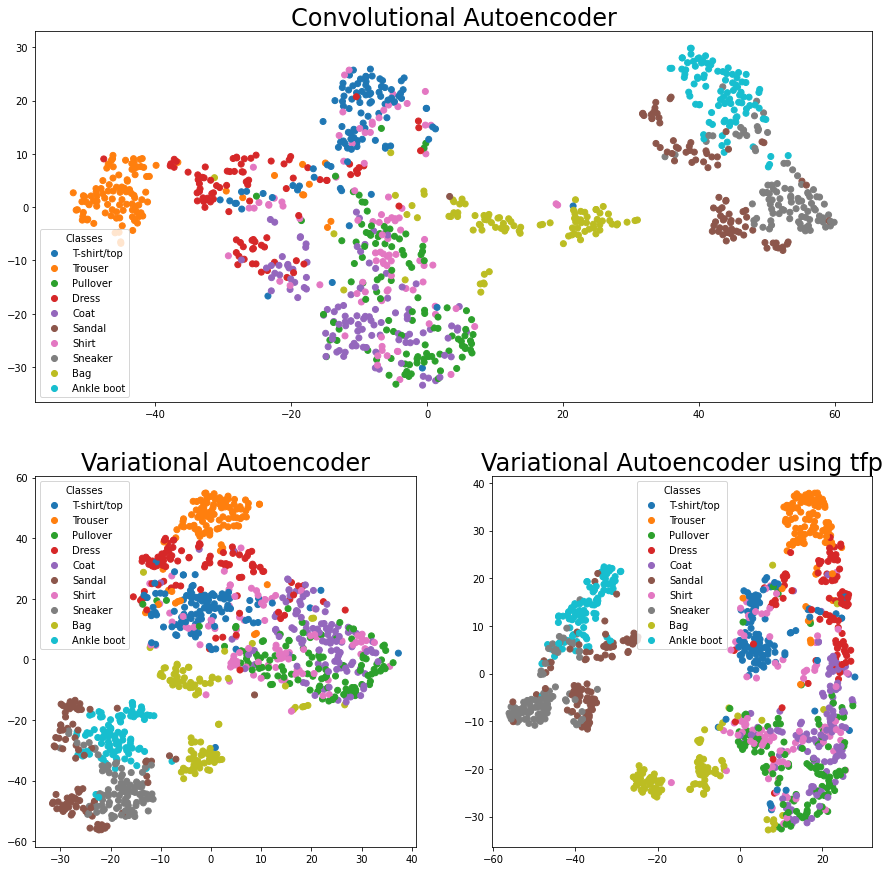

In [37]:
# Import t-SNE
from sklearn.manifold import TSNE

# Create embedding for first 1000 test images
embedded_images_conv = convAE.encoder(np.expand_dims(test_images[:1000]/255,(-1)).astype(np.float32)).numpy().squeeze()

embedded_images_variational = np.array(varAE(np.expand_dims(test_images[:1000]/255,(-1)).astype(np.float32), "encode"))
z_samples = [varAE.reparameterize(mean, logvar) for (mean, logvar) in zip(embedded_images_variational[0], embedded_images_variational[1])]

embedded_images_variational_tfp = var_tfp_AE.encoder(np.expand_dims(test_images[:1000]/255,(-1)).astype(np.float32)).mean().numpy()

tsne = TSNE(n_components=2)
autoencoder_tsne_conv = tsne.fit_transform(embedded_images_conv)
autoencoder_tsne_variational = tsne.fit_transform(z_samples)
autoencoder_tsne_variational_tfp = tsne.fit_transform(embedded_images_variational_tfp)

fig = plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.title('Convolutional Autoencoder',fontsize=24)
scatter=plt.scatter(autoencoder_tsne_conv[:,0],
                   autoencoder_tsne_conv[:,1],
                   c=test_labels[:1000],
                   cmap='tab10'
                  )

# Of course having labels inside the scatter function working like color would be to easy for matplotlib...👌
plt.legend(handles=scatter.legend_elements()[0], title="Classes", labels=explicit_labels)

plt.subplot(2,2,3)
plt.title('Variational Autoencoder',fontsize=24)
scatter=plt.scatter(autoencoder_tsne_variational[:,0],
                   autoencoder_tsne_variational[:,1],
                   c=test_labels[:1000],
                   cmap='tab10'
                  )

plt.legend(handles=scatter.legend_elements()[0], title="Classes", labels=explicit_labels)

plt.subplot(2,2,4)
plt.title('Variational Autoencoder using tfp',fontsize=24)
scatter=plt.scatter(autoencoder_tsne_variational_tfp[:,0],
                   autoencoder_tsne_variational_tfp[:,1],
                   c=test_labels[:1000],
                   cmap='tab10'
                  )

plt.legend(handles=scatter.legend_elements()[0], title="Classes", labels=explicit_labels)

plt.show()

When we analize the embeddings of our models using t-SNE, we can see that the resulting scatter plots share certain similarities.  
What interesting to see is, that the different kinds of shoes gets clustered together apart from the other clothes and that we get two clusters of bags (possible one for backpacks and one for handbags)

## Interpolation between 2 classes (Convolutional AE)

In [69]:
%%capture
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')
fig = plt.figure(figsize=(6,6))
plt.axis("off")

# Sample 2 embedding from the encoder

index_1 = np.random.choice(len(test_labels))
index_2 = np.random.choice(len(test_labels))

# Make sure we get samples from different classes
while test_labels[index_1] == test_labels[index_2]:
    index_2 = np.random.choice(len(test_labels))

img_1 = test_images[index_1]
img_2 = test_images[index_2]
label_1 = test_labels[index_1]
label_2 = test_labels[index_2]

embedding_1 = convAE.encoder(np.expand_dims(img_1/255,(0,-1)).astype(np.float32)).numpy()
embedding_2 = convAE.encoder(np.expand_dims(img_2/255,(0,-1)).astype(np.float32)).numpy()

steps = np.linspace(0,1,100)
interpolation_plots = []

for step in steps:
    title_txt = f'{int(100-step*100)}% {explicit_labels[label_1]} {int(step*100)}% {explicit_labels[label_2]}'
    title = plt.text(x = 1, y = -1.7, s = title_txt, fontsize = 18)
    img = plt.imshow(convAE.decoder(embedding_2*step+embedding_1*(1-step)).numpy().squeeze(),animated=True)
    interpolation_plots.append([img,title])
    
anim_conv=animation.ArtistAnimation(fig, interpolation_plots, interval=50)

In [70]:
anim_conv

## Interpolation between 2 classes (Variational)

In [71]:
%%capture
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')
fig = plt.figure(figsize=(6,6))
plt.axis("off")

embedding_1 = np.array(varAE.reparameterize(*varAE(np.expand_dims(img_1/255,(0,-1)).astype(np.float32), "encode")))
embedding_2 = np.array(varAE.reparameterize(*varAE(np.expand_dims(img_2/255,(0,-1)).astype(np.float32), "encode")))


steps = np.linspace(0,1,100)
interpolation_plots = []

for step in steps:
    title_txt = f'{int(100-step*100)}% {explicit_labels[label_1]} {int(step*100)}% {explicit_labels[label_2]}'
    title = plt.text(x = 1, y = -1.7, s = title_txt, fontsize = 18)
    img = plt.imshow(varAE(embedding_2*step+embedding_1*(1-step) , "decode").numpy().squeeze(),animated=True)
    interpolation_plots.append([img,title])
    
anim_var=animation.ArtistAnimation(fig, interpolation_plots, interval=50)

In [72]:
anim_var

## Interpolation between 2 classes (Variational AE using tfp)

In [73]:
%%capture
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')
fig = plt.figure(figsize=(6,6))
plt.axis("off")

embedding_1 = var_tfp_AE.encoder(np.expand_dims(img_1/255,(0,-1)).astype(np.float32)).mean().numpy()
embedding_2 = var_tfp_AE.encoder(np.expand_dims(img_2/255,(0,-1)).astype(np.float32)).mean().numpy()

steps = np.linspace(0,1,100)
interpolation_plots = []

for step in steps:
    title_txt = f'{int(100-step*100)}% {explicit_labels[label_1]} {int(step*100)}% {explicit_labels[label_2]}'
    title = plt.text(x = 1, y = -1.7, s = title_txt, fontsize = 18)
    img = plt.imshow(var_tfp_AE.decoder(embedding_2*step+embedding_1*(1-step)).mean().numpy().squeeze(),animated=True)
    interpolation_plots.append([img,title])
    
anim_var_tfp=animation.ArtistAnimation(fig, interpolation_plots, interval=50)

In [74]:
anim_var_tfp